In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import seaborn as sns

- Problem: Predicting Housing Prices in Ames,lowa
- Data:
 * 80 Features
 * Training set has 1460 examples & Evaluation has 1459 examples
- Framing the Problem:
 * Supervised Learning
 * Regression
 * Evaluation Metric: Root Mean Squeared Error(RMSE)

# Raw Data
- Structure of data: Tabular(정형) 데이터

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission_data = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train.shape,test.shape

((1460, 81), (1459, 80))

C:\Users\82109\AppData\Local\Temp\ipykernel_5428\4257204882.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'])


<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

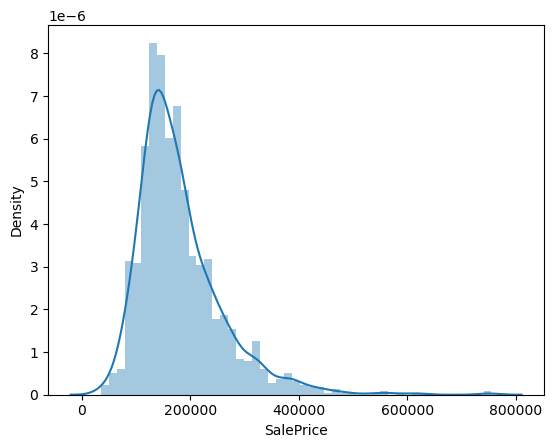

In [6]:
sns.distplot(train['SalePrice'])

# Feature Engineering

- start with analysing the missing values and correlations. this comes in handy when to check if every feature have enough unique values for the model

And wether we should dorp those features or not

## Missing Value

In [7]:
def Overview_Missing_Values(df):
#     ...
    
#     Input: DataFrame
#     Output:
#         -DataFrame with the number of missing values and the percentage of miss
#     ...
    
    # Get the null values
    null_values = df.isnull().sum()
    
    # Get the percentage of null values
    percentage_null_values = (null_values/df.shape[0]) * 100
    
    # Create the DataFrame with nulll values and the percentage of null_values
    null_df = pd.DataFrame({'Null Values':null_values, 'Percentage of Null': percentage_null_values})
    null_df = null_df.sort_values(by = 'Null Values', ascending = False)
    
    # Create a heatmap of missing values
    
    
    # Only return the rows with null values > 0
    head = null_df['Null Values'][null_df['Null Values']>0].count()
    return null_df.head(head)

In [8]:
Overview_Missing_Values(train)

,Null Values,Percentage of Null
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [9]:
def Overview_Correlation(df,target):
    """
    Input:
        df: DataFrame
        target: target column
    output:DataFrame with the correlation of the target with the other features
    """    

    # Get the correlation of the target with the other features
    df = df.select_dtypes(exclude = ['object']) # Object data 제거
    corr = df.corr()
    target_corr = corr[target]
    
    # Create a DataFrame with the correlation of the target with the other features
    corr_df = pd.DataFrame(target_corr.sort_values(ascending = False))
    
    return corr_df.head(len(target_corr))

In [10]:
Overview_Correlation(train,'SalePrice')

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


## Not enough Unique Values

In [11]:
def Overview_Unique_Values(df,percentage = 0.85):
#     ...
#     Input: DataFrame
#     Output: print the unique values and the percentage of unique values
#     ...
    for i in df.columns:
        # We get the number of null values also, becaues it is not counted as a unique value
        sum_null = df[i].isnull().sum()
        max_value = df[i].value_counts().max()
        if max_value > sum_null:
            # Check if the unique value is more than 85% of the total values
            if max_value > df.shape[0]*percentage:
                print(f'{i} consist {(max_value/df.shape[0])*100}% out of unique values:{df[i].value_counts().index.max()}')
                print(df[i].value_counts())
                print('/////////////////////////////////////////////////////')
        else:
             # Check if the null values is more than 85% of the total values
                if sum_null > df.shape[0]*percentage:
                    print(f'{i} consist {(sum_null/df.shape[0])*100}% out of null values')
                    print(df[i].value_counts())
                    print('/////////////////////////////////////////////////////')
                

In [12]:
Overview_Unique_Values(train, 0.9)

Street consist 99.58904109589041% out of unique values:Pave
Pave    1454
Grvl       6
Name: Street, dtype: int64
/////////////////////////////////////////////////////
Alley consist 93.76712328767123% out of null values
Grvl    50
Pave    41
Name: Alley, dtype: int64
/////////////////////////////////////////////////////
Utilities consist 99.93150684931507% out of unique values:NoSeWa
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
/////////////////////////////////////////////////////
LandSlope consist 94.65753424657535% out of unique values:Sev
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
/////////////////////////////////////////////////////
Condition2 consist 98.97260273972603% out of unique values:RRNn
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
/////////////////////////////////////////////////////
RoofMatl consist 98.21917808219179% out of unique

Features that consist of 95-100 Unique value or a null value is not going to affect the prediction so, drop the columns

In [13]:
drop_cols = ['Id','Street','Alley','Utilities','Condition2','RoofMatl','Heating','CentralAir','Electrical','LowQualFinSF','KitchenAbvGr','3SsnPorch','PoolArea','PoolQC','MiscFeature','MiscVal']

train = train.drop(drop_cols, axis =1)
test = test.drop(drop_cols, axis = 1)

In [14]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'SalePrice'],

In [16]:
def Overview_Inconsistencies(train,test,target):
#     ...
#     Input: train: train dataset
#             test: test dataset
#             target: target column
#     output:
#         - print the inconsitencies between the train and test dataFrame
#         - print the value counts in train
#         - print the value counts in test
#         - print the average sale price of the inconsistencies
#     ...
    for i in train.columns:
        if i == target:
            continue
            
        #Get the Unique values
        train_1 = train[i].value_counts().index.unique()
        test_1 = test[i].value_counts().index.unique()
            
        # Check if there are inconsistencies
        inconst_train = list(set(train_1)-set(test_1))
        inconst_test = list(set(test_1)- set(train_1))
        if len(inconst_train) > 0 or len(inconst_test) > 0:
            print(f'{i}')
            print(f'Only in train[{i}]:' + str(inconst_train[:5]))
            print(f'Only in test[{i}]:' + str(inconst_test[:5]))
            print("--------------------------------------------------")
            print("Train - Value Counts")
            print(train[i].value_counts())
            print("--------------------------------------------------")
            print("Test - Value Counts")
            print(test[i].value_counts())
            print("--------------------------------------------------")
            print('Average Sale Price')
            print(train.groupby(i)[target].mean())
            print("//////////////////////////////////////////////////")

In [17]:
Overview_Inconsistencies(train,test,"SalePrice")

MSSubClass
Only in train[MSSubClass]:[]
Only in test[MSSubClass]:[150]
--------------------------------------------------
Train - Value Counts
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
--------------------------------------------------
Test - Value Counts
20     543
60     276
50     143
120     95
30      70
70      68
160     65
80      60
90      57
190     31
85      28
75       7
180      7
45       6
40       2
150      1
Name: MSSubClass, dtype: int64
--------------------------------------------------
Average Sale Price
MSSubClass
20     185224.811567
30      95829.724638
40     156125.000000
45     108591.666667
50     143302.972222
60     239948.501672
70     166772.416667
75     192437.500000
80     169736.551724
85     147810.000000
90     133541.076923
120    200779.080460
160    138647.380952
180    102300.000000
190    1

GrLivArea
334      39300.0
438      60000.0
480      35311.0
520      68500.0
605      86000.0
          ...   
3627    625000.0
4316    755000.0
4476    745000.0
4676    184750.0
5642    160000.0
Name: SalePrice, Length: 861, dtype: float64
//////////////////////////////////////////////////
FullBath
Only in train[FullBath]:[]
Only in test[FullBath]:[4]
--------------------------------------------------
Train - Value Counts
2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64
--------------------------------------------------
Test - Value Counts
2    762
1    659
3     31
4      4
0      3
Name: FullBath, dtype: int64
--------------------------------------------------
Average Sale Price
FullBath
0    165200.888889
1    134751.440000
2    213009.825521
3    347822.909091
Name: SalePrice, dtype: float64
//////////////////////////////////////////////////
BedroomAbvGr
Only in train[BedroomAbvGr]:[8]
Only in test[BedroomAbvGr]:[]
-------------------------------------------------

- Change the inconsistent value or column in train/test to a value or column that almost the same in train.test or use the mean

In [18]:
len(train['BsmtUnfSF'].unique())

780

In [19]:
train['HouseStyle'] = train['HouseStyle'].replace(['2.5Fin'],['2Story'])
train['Exterior1st'] = train['Exterior1st'].replace(['Stone', 'ImStucc'],['CemntBd','CemntBd'])
train['Exterior2nd'] = train['Exterior2nd'].replace(['Other'],['ImStucc'])
train['TotRmsAbvGrd'] = train['TotRmsAbvGrd'].replace([14,2],[12,3])
test['TotRmsAbvGrd'] = test['TotRmsAbvGrd'].replace([13,15],[12,12])
train['BedroomAbvGr'] = train['BedroomAbvGr'].replace([8],[6])
train['GarageQual'] = train['GarageQual'].replace(['Ex'],['Gd'])
test['MSSubClass'] = test['MSSubClass'].replace([150],[160])
test['Fireplaces'] = test['Fireplaces'].replace([4],[3])
test['GarageCars'] = test['GarageCars'].replace([5],[4])

## Impute Missing Values

- Impute 0 or None when zero of somethin is possible
    - Example: Some house have an garage and others don't. So impute 0 or No Garage
    - df['a'] = df['a'].fillna(0)
- Impute mean when zero of something is not possible
    - Example: A house has always an lot area. A lot area of 0 doesn't exist
    - df['a'] = df['a'].fillna(df['a'].mean())

In [20]:
Overview_Missing_Values(test)

,Null Values,Percentage of Null
Fence,1169,80.123372
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageCond,78,5.346127
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127
GarageQual,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtQual,44,3.015764


In [21]:
test["GarageType"].value_counts()

Attchd     853
Detchd     392
BuiltIn     98
Basment     17
2Types      17
CarPort      6
Name: GarageType, dtype: int64

In [22]:
train['Fence'] = train['Fence'].fillna('No Fence')
test['Fence'] = test['Fence'].fillna('No Fence')

train['FireplaceQu'] = train['FireplaceQu'].fillna('No FireplaceQu')
test['FireplaceQu'] = test['FireplaceQu'].fillna('No FireplaceQu')

train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')
test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')

train['GarageQual'] = train['GarageQual'].fillna('No Garage')
test['GarageQual'] = test['GarageQual'].fillna('No Garage')

train['GarageCond'] = train['GarageCond'].fillna('No Garage')
test['GarageCond'] = test['GarageCond'].fillna('No Garage')

train['GarageType'] = train['GarageType'].fillna('No Garage')
test['GarageType'] = test['GarageType'].fillna('No Garage')

train['FireplaceQu'] = train['FireplaceQu'].fillna('No FireplaceQu')
test['FireplaceQu'] = test['FireplaceQu'].fillna('No FireplaceQu')

train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')

train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')

train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')
test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')

train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')
test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')

train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')

train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')

train['MasVnrType'] = train['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [23]:
test['MSZoning'] = test['MSZoning'].fillna("C (all)")
test['Functional'] = test['Functional'].fillna("Typ")
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)
test['KitchenQual'] = test['KitchenQual'].fillna('TA')
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
test['Exterior2nd'] = test['Exterior2nd'].fillna("VinylSd")
test['Exterior1st'] = test['Exterior1st'].fillna("VinylSd")
test['GarageCars'] = test['GarageCars'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)
test['SaleType'] = test['SaleType'].fillna("WD")

In [24]:
# Check the final null
Overview_Missing_Values(train), Overview_Missing_Values(test)

(Empty DataFrame
 Columns: [Null Values, Percentage of Null]
 Index: [],
 Empty DataFrame
 Columns: [Null Values, Percentage of Null]
 Index: [])

## Fix Outliers


-Check which features are numerical

In [25]:
train_num = train.select_dtypes(exclude = ['object'])
print(train_num.columns)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')


In [26]:
def Check_Scatter(df,target):
    # ...
    # Input:
    #     df: DataFrame
    #     target: target column
    # output:
    #         -Print the scatterplot between all the features and target
    # ...
    for i in range(0,len(df.columns),5):
        sns.pairplot(data = df,
                x_vars = df.columns[i:i+5],
                y_vars = [target])

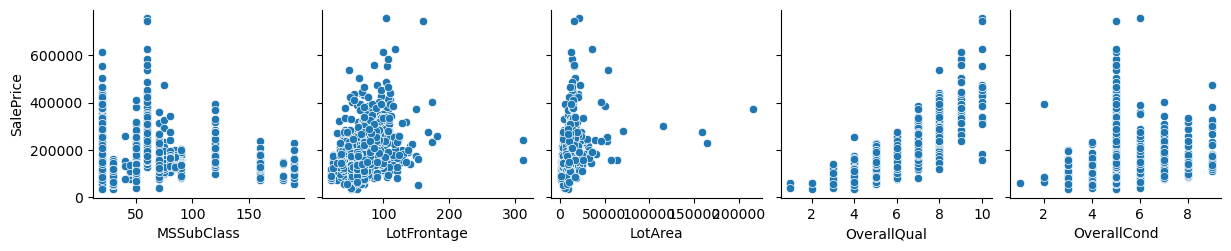

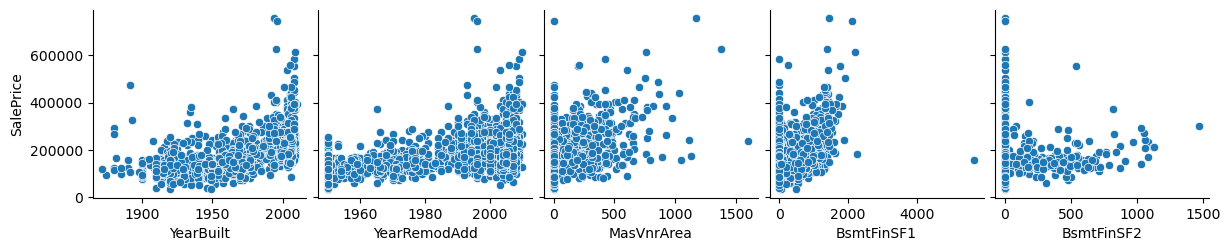

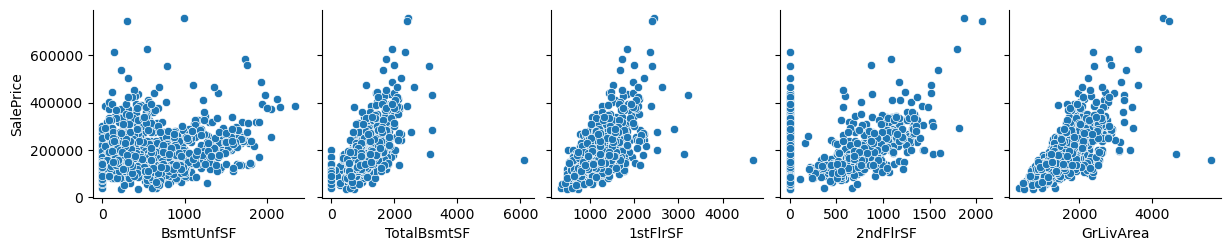

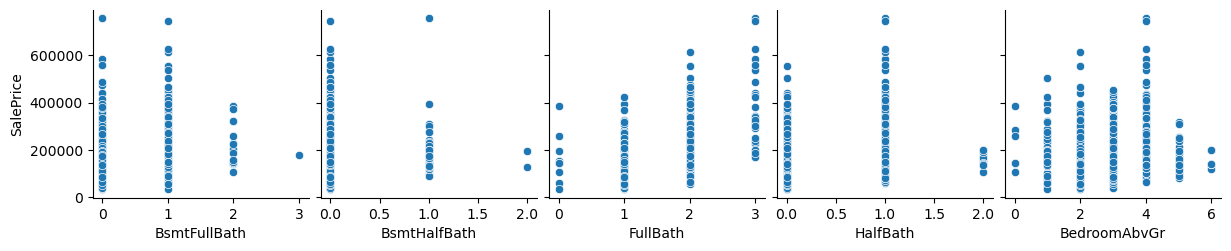

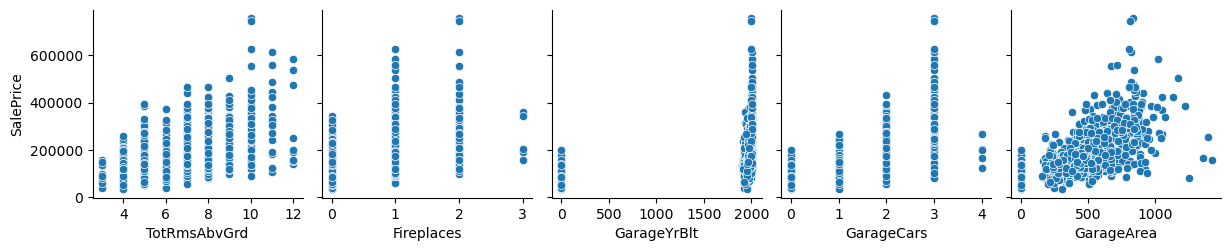

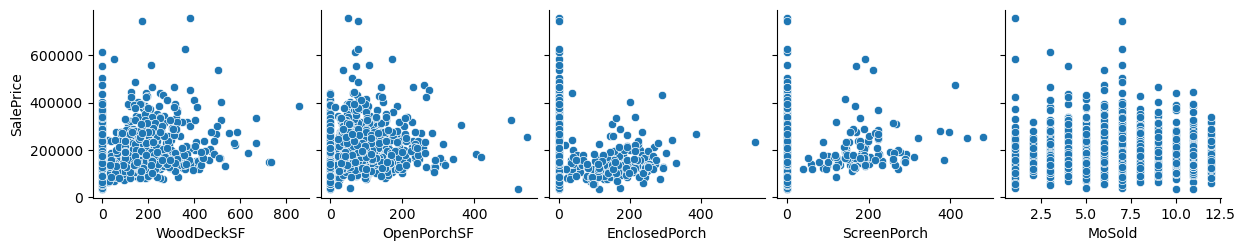

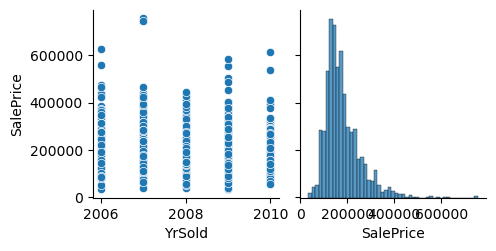

In [27]:
Check_Scatter(train_num,"SalePrice")

In [28]:
def Check_Outliers(df,target,feature,num,operator):
#     ...
#     Input:
#         -df: dataFrame
#         -target: target column
#         -feature: feature column
#         -num: Number
#         -operator: Operator
            
#     output:
#         -Scatterplot before removing outliers
#         -Scatterplot after removing outliers
#         -Correlation before removing outliers
#         -Correlation after removing outliers
#         -Difference between the correlation before and after removing outliers
#     ...

    #Scatterplot before removing outliers
    sns.relplot(kind = 'scatter', data = df,x =feature , y=target)
    before_corr = df[feature].corr(df[target])
    
    #Scatterplot after removing outliers
    a_df = df.copy()
    if operator == 'greater':
        a_df.loc[a_df[feature] > num,feature] = num
    elif operator == 'smaller':
        a_df.loc[a_df[feature] < num,feature] = num
    sns.relplot(kind = 'scatter',data = a_df, x= feature, y=target)    
    after_corr = a_df[feature].corr(a_df[target])
    #Difference between the correlation before and after removing outliers
    print(f'Before: {before_corr}')
    print(f'After: {after_corr}')
    print(f'Difference: {(after_corr-before_corr)/before_corr*100}%')

Before: 0.3244134445681295
After: 0.32869656857295076
Difference: 1.3202671086961657%


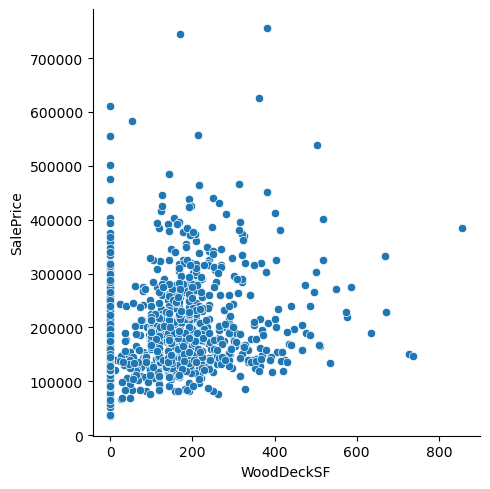

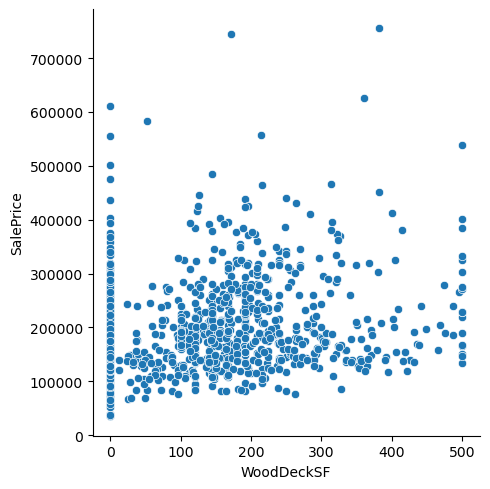

In [29]:
Check_Outliers(train_num,"SalePrice", 'WoodDeckSF',500,'greater')

In [30]:
train.loc[train['LotFrontage']>180,'LotFrontage'] = 180
test.loc[test['LotFrontage']>180,'LotFrontage'] = 180

train.loc[train['LotArea']>45000,'LotArea'] = 45000
test.loc[test['LotArea']>45000,'LotArea'] = 45000

train.loc[train['YearBuilt']<1900,'LotArea'] = 1900
test.loc[test['YearBuilt']<1900,'LotArea'] = 1900

train.loc[train['MasVnrArea']>1000,'LotArea'] = 1000
test.loc[test['MasVnrArea']>1000,'LotArea'] = 1000

train.loc[train['BsmtFinSF1']>3000,'BsmtFinSF1'] = 3000
test.loc[test['BsmtFinSF1']>3000,'BsmtFinSF1'] = 3000

train.loc[train['TotalBsmtSF']>3000,'TotalBsmtSF'] = 3000
test.loc[test['TotalBsmtSF']>3000,'TotalBsmtSF'] = 3000

train.loc[train['1stFlrSF']>3500,'1stFlrSF'] = 3500
test.loc[test['1stFlrSF']>3500,'1stFlrSF'] = 3500

train.loc[train['LotArea']>45000,'LotArea'] = 45000
test.loc[test['LotArea']>45000,'LotArea'] = 45000

train.loc[train['GarageArea'] > 1150,'GarageArea'] = 1150
test.loc[test['GarageArea'] > 1150,'GarageArea'] = 1150

train.loc[train['GarageCars'] > 3,'GarageCars'] = 3
test.loc[test['GarageCars'] > 3,'GarageCars'] = 3

train.loc[train['Fireplaces'] > 3,'Fireplaces'] = 3
test.loc[test['Fireplaces'] > 3,'Fireplaces'] = 3

train.loc[train['WoodDeckSF'] > 500,'WoodDeckSF'] = 500
test.loc[test['WoodDeckSF'] > 500,'WoodDeckSF'] = 500

train.loc[train['OpenPorchSF'] > 300,'OpenPorchSF'] = 300
test.loc[test['OpenPorchSF'] > 300,'OpenPorchSF'] = 300

train.loc[train['EnclosedPorch'] > 300,'EnclosedPorch'] = 300
test.loc[test['EnclosedPorch'] > 300,'EnclosedPorch'] = 300


# Feature Extraction

- Changing DataType
    - Check if correlation didn't change
- Changing Values
    - Check if correlation didn't change
    - Example:
        - Year to Age is a continuous value that can provide more information about the data than year of an event

- Combining Features
    - Check if correlation didn't change
    - train['Bedrooms'] = train['Bedroom1'] + train['Bedroom2'] +train['Bedroom3']

- Changing Values


In [31]:
train_num.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

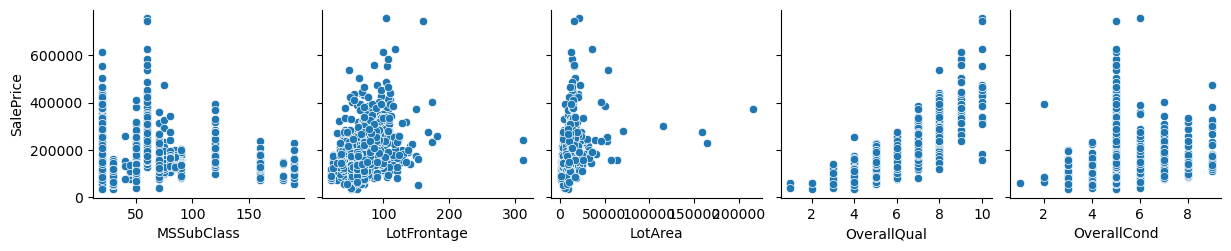

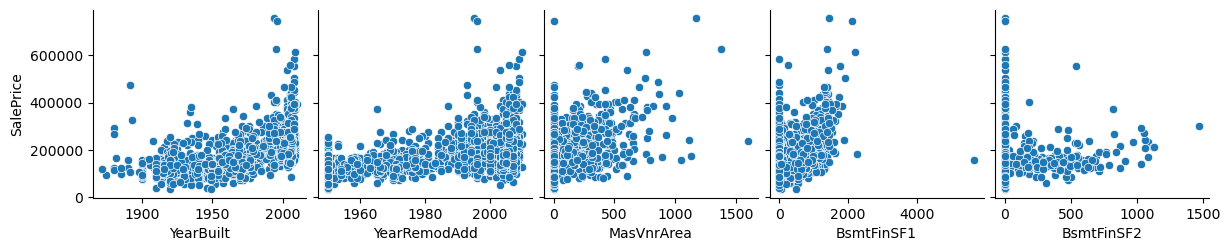

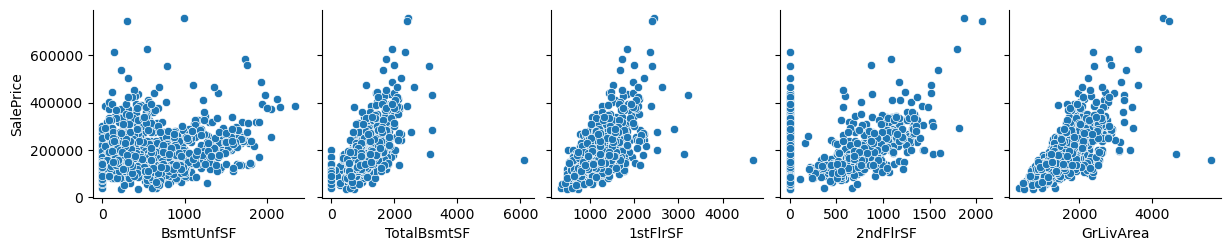

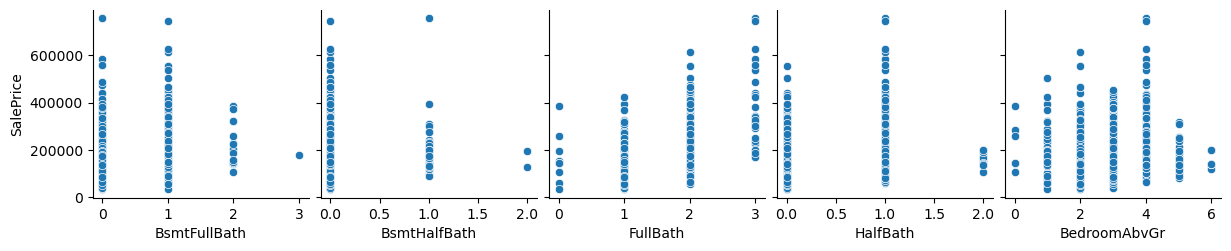

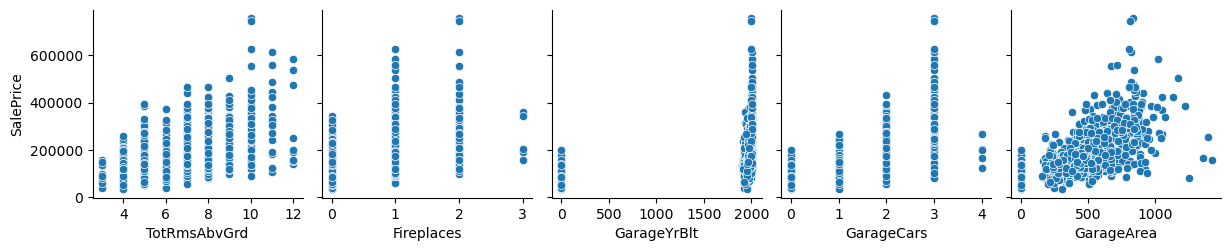

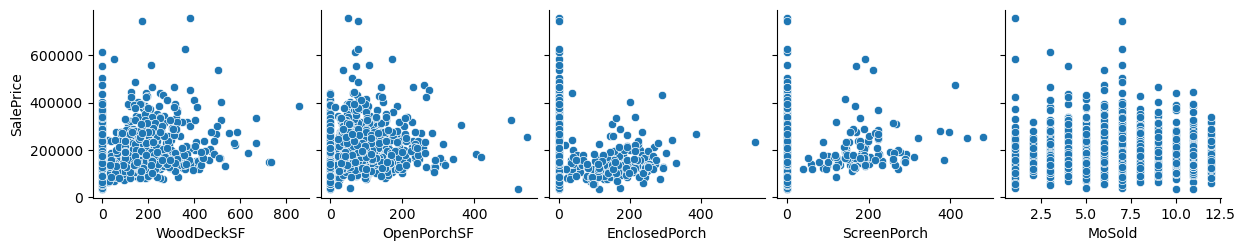

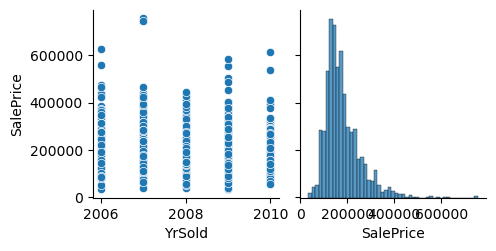

In [32]:
Check_Scatter(train_num,"SalePrice")

In [33]:
# Total amount of baths in the house
train['TotalBath'] = train["BsmtFullBath"]+train["BsmtHalfBath"]*0.5+train["FullBath"]+train["HalfBath"]*0.5
test['TotalBath'] = test["BsmtFullBath"]+test["BsmtHalfBath"]*0.5+test["FullBath"]+test["HalfBath"]*0.5

# Total square feet of porch
train['TotalPorchSF'] = train["OpenPorchSF"]+train["EnclosedPorch"]+train["ScreenPorch"]
test['TotalPorchSF'] = test["OpenPorchSF"]+test["EnclosedPorch"]+test["ScreenPorch"]

#Total square feet of house
train['TotalSF'] = train["TotalBsmtSF"]+train["1stFlrSF"]+train["2ndFlrSF"]
test['TotalSF'] = test["TotalBsmtSF"]+test["1stFlrSF"]+test["2ndFlrSF"]

# Total Garage
train['TotalGarage'] = train["GarageCars"]+train["GarageArea"]
test['TotalGarage'] = test["GarageCars"]+test["GarageArea"]

# Convert year to age
train['Age'] = 2010 - train['YearBuilt']
test['Age'] = 2010 - test['YearBuilt']

train['Garage_Age'] = 2010 - train['GarageYrBlt']
test['Garage_Age'] = 2010 - test['GarageYrBlt']

train['Age_sold'] = 2010 - train['YrSold']
test['Age_sold'] = 2010 - test['YrSold']

train['Remodafter'] = train['YearRemodAdd'] - train['YearBuilt']
test['Remodafter'] = test['YearRemodAdd'] - test['YearBuilt']

- Changing Data Types

In [34]:
train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

## Ordinal Categories
- Check if the values in categorical features are in a ranking order

In [35]:
def Overview_Categories(df):
    """
    Input: DataFrame
    Output: DataFrame with only categorical features, the unique values and  the number of unique value
    """
    # Categorical features
    df_categories = df.select_dtypes(include = ['object'])
    
    # Create DataFrame
    overview_categories = pd.DataFrame(df_categories.columns,columns = ['Feature'])
    
    # Add unique values and counts
    unique_values = []
    unique_counts = []
    for col in df_categories.columns:
        unique_values.append(df_categories[col].unique())
        unique_counts.append(len(df_categories[col].unique()))
    overview_categories['Categories'] = unique_values
    overview_categories['Number'] = unique_counts
        
    return overview_categories.head(len(overview_categories))

In [36]:
Overview_Categories(train)

,Feature,Categories,Number
0,MSSubClass,"[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...",15
1,MSZoning,"[RL, RM, C (all), FV, RH]",5
2,LotShape,"[Reg, IR1, IR2, IR3]",4
3,LandContour,"[Lvl, Bnk, Low, HLS]",4
4,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]",5
5,LandSlope,"[Gtl, Mod, Sev]",3
6,Neighborhood,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...",25
7,Condition1,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...",9
8,BldgType,"[1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]",5
9,HouseStyle,"[2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...",7


In [37]:
ordinal_categories = ['MSSubClass','SaleCondition','Fence','SaleType','PavedDrive','GarageCond','GarageQual','GarageFinish','GarageType','FireplaceQu','Functional','KitchenQual','HeatingQC','BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtCond','BsmtQual','Foundation','ExterCond','ExterQual','MasVnrType','Exterior2nd','Exterior1st','RoofStyle','HouseStyle','BldgType','Condition1','Neighborhood','LandSlope','LotConfig','LandContour','LotShape','MSZoning']

<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

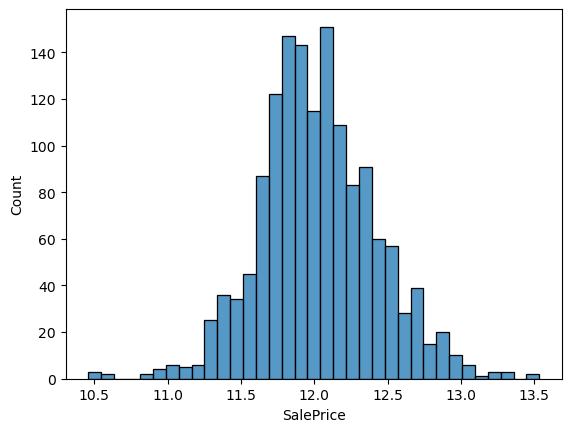

In [38]:
# Transform the skewness of target data 
y = train['SalePrice']
y = np.log1p(y)
sns.histplot(y)

# Transformation

In [39]:
print('Train Shape' + str(train.shape))
print('Test Shape' + str(test.shape))

Train Shape(1460, 73)
Test Shape(1459, 72)


- Convert Categorical Data into One-Hot Encoding

In [40]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

- Check for inconsistencies between columns

In [41]:
print("\nOnly in Train: "+ str(list(set(train.columns) - set(test.columns))))
print("Only in Test: "+ str(list(set(test.columns) - set(train.columns))))


Only in Train: ['SalePrice']
Only in Test: []


- Skewness
 - If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
 - If the skewness is bewween -1 and -0.5 or between 0.5 and 1 are moderately skewed.
 - if the skewness is lessthan -1 or greater than 1, the data are highly skewed.

In [42]:
def Check_Skewness(df):
#     ...
#     Input: dataframe
#     output: Dataframe skewness of the features
#     ...
    # Get the skewness of the features
    skewed_features = df.apply(lambda x: x.skew()).sort_values(ascending = False)
    # Create the DataFrame
    skewness_table = pd.DataFrame({'Skew':skewed_features})
    return skewness_table.head(30)

In [43]:
Check_Skewness(train)

,Skew
Exterior2nd_CBlock,38.209946
Exterior1st_CBlock,38.209946
Exterior1st_AsphShn,38.209946
Functional_Sev,38.209946
HeatingQC_Po,38.209946
ExterCond_Po,38.209946
RoofStyle_Shed,26.990701
SaleType_Con,26.990701
Exterior1st_BrkComm,26.990701
GarageCond_Ex,26.990701


In [44]:
def Log_Transform(train,test,target,threshold):
    """
    Input: 
        - train: training set
        - test: test set
        - target: target column
        - threshold: Skewness
    Output:
        - train: Training set with log transfromation
        - test: Test set with log transformation
    """
    # Get the skewness of the features
    skew_features = train.apply(lambda x: x.skew()).sort_values(ascending = False)
    skew_table = pd.DataFrame({'Skew':skew_features})    
    # Get the features with skewness greater than skewness
    skewness = skew_table[abs(skew_table)> threshold]
    # Create new DataFrames
    train_skew = train.copy()
    test_skew = test.copy()
    # Log Transfromation
    for i in skewness.index:
        if i == target:
            continue
        train_skew[i] = np.log1p(train_skew[i])
        test_skew[i] = np.log1p(test_skew[i])
    return train_skew,test_skew

In [45]:
train_skew,test_skew = Log_Transform(train,test,"SalePrice",1)

C:\Users\82109\anaconda3\envs\MachineLearning\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\82109\anaconda3\envs\MachineLearning\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
Check_Skewness(train_skew)

,Skew
Exterior1st_AsphShn,38.218750
Exterior1st_CBlock,38.218750
Functional_Sev,38.218750
Exterior2nd_CBlock,38.218750
HeatingQC_Po,38.218750
ExterCond_Po,38.218750
SaleType_Con,26.984375
BsmtCond_Po,26.984375
Condition1_RRNe,26.984375
GarageCond_Ex,26.984375


In [47]:
def Check_INF_values(df):
    """
    Input: Dataframe
    Output: Print the features with infinite values
    """
    # Check for infinite values
    for i in df.columns:
        if ((df[i] == np.inf) | (df[i] == -np.inf)).sum() > 0:
            print(i)
    print('Done')

In [48]:
Check_INF_values(train_skew)

Done


In [49]:
Check_INF_values(test_skew)

Remodafter
Done


In [50]:
test_skew = test_skew.replace([np.inf,-np.inf],[0,0])
Check_INF_values(test_skew)

Done


In [51]:
Overview_Missing_Values(test_skew)

,Null Values,Percentage of Null
Garage_Age,1,0.06854


In [52]:
test_skew = test_skew.fillna(0)

In [6]:
train_skew.drop('SalePrice',inplace =True)

NameError: name 'train_skew' is not defined

# Training Models

In [2]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

from sklearn.linear_model import Ridge,RidgeCV,  ElasticNet, Lasso,LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [3]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [5]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=train_skew):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

NameError: name 'train_skew' is not defined

## Setup Models

In [ ]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=300,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=300,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=300,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=300,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Train Models

Get cross validation scores for each model

In [ ]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

## Fit the models

In [ ]:
print('stack_gen')
stack_gen_model = stack_gen.fit(train_skew, y)

In [ ]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(train_skew, y)

In [ ]:
print('xgboost')
xgb_model_full_data = xgboost.fit(train_skew, y)

In [ ]:
print('Svr')
svr_model_full_data = svr.fit(train_skew, y)

In [ ]:
print('Ridge')
ridge_model_full_data = ridge.fit(train_skew, y)

In [ ]:
print('RandomForest')
rf_model_full_data = rf.fit(train_skew, y)

In [ ]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(train_skew, y)

- Blend models and get predictions

In [ ]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [ ]:
# Get final precitions from the blended model
blended_score = rmsle(y, blended_predictions(train_skew))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

In [ ]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ sin scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [ ]:
# Read in sample_submission dataframe
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

In [ ]:
# Append predictions from blended models
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(test_skew)))

In [ ]:
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_regression1.csv", index=False)

In [ ]:
# Scale predictions
submission['SalePrice'] *= 1.001619
submission.to_csv("submission_regression2.csv", index=False)